In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import datetime
import time
import seaborn as sns
import psutil
import cv2

from sklearn.model_selection import train_test_split

from collections import Counter

import sys

assert sys.version_info >= (3, 7)

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
import tensorflow as tf
import pandas as pd
# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)        

1 Physical GPUs, 1 Logical GPUs


In [ ]:
train_byclass = pd.read_csv('emnist-byclass-train.csv', header=None)
test_byclass = pd.read_csv('emnist-byclass-test.csv', header=None)

In [ ]:
s_alph=list(string.ascii_lowercase)
l_alph=list(string.ascii_uppercase)
number = [str(i) for i in range(10)]
byclass_classes=np.transpose(number+l_alph+s_alph)
print(byclass_classes) 

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [ ]:
 # data label 나누기
X_train = train_byclass.iloc[:, 1:].to_numpy()
train_labels = np.transpose(byclass_classes[train_byclass.iloc[:,0].tolist()])
X_test = test_byclass.iloc[:, 1:].to_numpy()
test_labels = np.transpose(byclass_classes[test_byclass.iloc[:,0].tolist()])

In [ ]:
y_train = pd.get_dummies(train_labels).to_numpy()
y_test = pd.get_dummies(test_labels).to_numpy()

In [ ]:
y_train=np.argmax(y_train,axis=-1)
y_test=np.argmax(y_test,axis=-1)


In [ ]:
#train val test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [ ]:
from tensorflow.keras.utils import to_categorical
X_train= X_train.reshape(-1, 28, 28, 1).astype(float)
X_val= X_val.reshape(-1, 28, 28, 1).astype(float)
X_test= X_test.reshape(-1, 28, 28, 1).astype(float)

X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255



In [ ]:
del train_byclass, test_byclass, byclass_classes, train_labels, test_labels

In [ ]:
X_train.shape


(558345, 28, 28, 1)

**mobilenet pretrained

In [ ]:
#resize 함수인데 코드 너무 오래걸림
import cv2
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils

from skimage.transform import resize
from skimage.transform import resize

# MNIST 데이터셋으로부터 이미지를 가져옵니다.
X_train_resized = np.zeros((X_train.shape[0], 32, 32, 3), dtype=np.float32)
X_test_resized = np.zeros((X_test.shape[0], 32, 32, 3), dtype=np.float32)
X_val_resized = np.zeros((X_val.shape[0], 32, 32, 3), dtype=np.float32)


# 훈련 이미지를 32x32 크기로 변경합니다.
for i in range(X_train_resized.shape[0]):
    resized_image = resize(X_train[i], (32, 32), anti_aliasing=True)
    X_train_resized[i] = np.repeat(resized_image, 1, axis=-1)
# 테스트 이미지를 32x32 크기로 변경합니다.
for i in range(X_test_resized.shape[0]):
    resized_image = resize(X_test[i], (32, 32), anti_aliasing=True)
    X_test_resized[i] = np.repeat(resized_image, 1, axis=-1)
# 검증 이미지를 32x32 크기로 변경합니다.
for i in range(X_val_resized.shape[0]):
    resized_image = resize(X_val[i], (32, 32), anti_aliasing=True)
    X_val_resized[i] = np.repeat(resized_image, 1, axis=-1)


In [ ]:
X_val_resized.shape 

(139587, 32, 32, 3)

In [ ]:
y_train.shape


(558345,)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow import keras

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(32, 32, 3),weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

output = tf.keras.layers.Dense(62, activation="softmax")(avg) # 클래스 수에 따라 수정

optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model_MobileNetV2 = Model(inputs=base_model.input, outputs=output)
# 모델 컴파일
model_MobileNetV2.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

from tensorflow import keras
start = time.time()
# Compile, train and evaluate
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

history = model_MobileNetV2.fit(X_train_resized, y_train_one_hot ,epochs=100,batch_size=64, verbose=1, validation_data=(X_val_resized,y_val_one_hot), callbacks = [early_stopping_cb])
MobileNet_train_time = time.time()-start

print("training time : ", time.time()-start, "s")

In [ ]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

model_MobileNetV2.summary()


ES = EarlyStopping(monitor='val_loss', patience=5)
CB = keras.callbacks.ModelCheckpoint('model_MobileNetV2.h5', save_best_only=True)
RLP = ReduceLROnPlateau(monitor='val_loss', patience=4, min_lr=1e-4)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 16, 16, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 16, 16, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 16, 16, 32)   0           ['bn_Conv1[0][0]']               
                                                                                              

In [ ]:
model_MobileNetV2

In [ ]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132),range(132,154)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_1                33: block_3_depthwise_relu 66: block_7_depthwise      99: block_11_expand_BN    132: block_14_project_BN   
  1: Conv1                  34: block_3_project        67: block_7_depthwise_BN  100: block_11_expand_relu  133: block_14_add          
  2: bn_Conv1               35: block_3_project_BN     68: block_7_depthwise_relu101: block_11_depthwise    134: block_15_expand       
  3: Conv1_relu             36: block_4_expand         69: block_7_project       102: block_11_depthwise_BN 135: block_15_expand_BN    
  4: expanded_conv_depthwise 37: block_4_expand_BN      70: block_7_project_BN    103: block_11_depthwise_relu136: block_15_expand_relu  
  5: expanded_conv_depthwise_BN 38: block_4_expand_relu    71: block_7_add           104: block_11_project      137: block_15_depthwise    
  6: expanded_conv_depthwise_relu 39: block_4_depthwise      72: block_8_expand        105: block_11_project_BN   138: block_15_depthwise_BN 
  7: expanded_conv_project  40: bloc

In [ ]:
for layer in model_MobileNetV2.layers:
    layer.trainable = True

In [ ]:
n_epochs = 30

history=model_MobileNetV2.fit(X_train_resized,y_train,epochs=n_epochs, batch_size=128,verbose=1, validation_data=(X_val_resized,y_val),callbacks=[ES,CB,RLP])

Epoch 1/30
4363/4363 [==============================] - 84s 18ms/step - loss: 0.5622 - accuracy: 0.8138 - val_loss: 0.6600 - val_accuracy: 0.8086 - lr: 0.0010
Epoch 2/30
4363/4363 [==============================] - 78s 18ms/step - loss: 0.4328 - accuracy: 0.8458 - val_loss: 0.5959 - val_accuracy: 0.8219 - lr: 0.0010
Epoch 3/30
4363/4363 [==============================] - 80s 18ms/step - loss: 0.4369 - accuracy: 0.8473 - val_loss: 3.6666 - val_accuracy: 0.3596 - lr: 0.0010
Epoch 4/30
4363/4363 [==============================] - 84s 19ms/step - loss: 0.4328 - accuracy: 0.8461 - val_loss: 0.4451 - val_accuracy: 0.8470 - lr: 0.0010
Epoch 5/30
4363/4363 [==============================] - 80s 18ms/step - loss: 0.4593 - accuracy: 0.8407 - val_loss: 2.1157 - val_accuracy: 0.5751 - lr: 0.0010
Epoch 6/30
4363/4363 [==============================] - 82s 19ms/step - loss: 0.4847 - accuracy: 0.8334 - val_loss: 0.4737 - val_accuracy: 0.8343 - lr: 0.0010
Epoch 7/30
4363/4363 [========================

In [ ]:

start = time.time()
print(model_MobileNetV2.evaluate(X_test_resized,y_test))

MobileNet_test_time = time.time()-start
print("inference time : ",  time.time()-start, "s")

3636/3636 [==============================] - 24s 7ms/step - loss: 0.3338 - accuracy: 0.8743
[0.33380502462387085, 0.8743155002593994]
inference time :  25.033626317977905 s


Text(0.5, 1.0, 'Loss Curves')

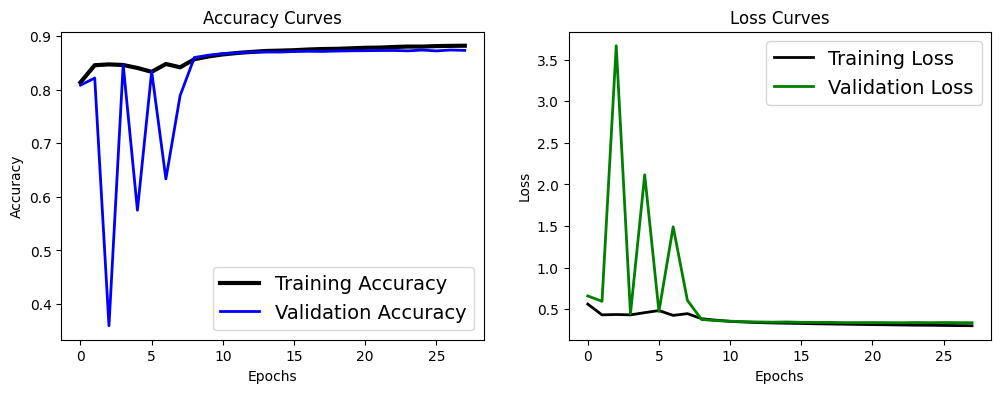

In [ ]:
# Accuracy curve
plt.figure(figsize=[12,4])
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history.history['accuracy'], 'black', linewidth=3.0)
ax1.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

# Loss curve
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history.history['loss'], 'black', linewidth=2.0)
ax2.plot(history.history['val_loss'], 'green', linewidth=2.0)
ax2.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)